<div style="border:solid green 2px; padding: 20px">
    
<b>Игорь, привет!</b> Мы рады тебя видеть на территории код-ревьюеров 😎. Ты проделал большую работу над проектом, но давай познакомимся и сделаем его еще лучше! У нас тут своя атмосфера и несколько правил:


1. Меня зовут Александр Матвеевский. Я работаю код-ревьюером, моя основная цель — не указать на совершенные тобою ошибки, а поделиться своим опытом и помочь тебе стать дата-специалистом.
2. Общаемся на ты.
3. Если хочешь написать, спросить - не нужно стесняться. Только выбери свой цвет для комментария.  
4. Это учебный проект, тут можно не бояться сделать ошибку.  
5. У нас с тобой 6 попыток для сдачи проекта.  
6. Let's Go!

---

Я буду красить комментарии цветом, пожалуйста, не удаляй их:

<div class="alert alert-block alert-danger">✍
    

__Комментарий от ревьюера №1__

Такой комментарий нужно исправить обязательно, он критически влияет на удачное выполнение проекта.
</div>
    
---

<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__


Такой комментарий является рекомендацией или советом. Можешь использовать их на своё усмотрение.
</div>

---

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Такой комментарий  говорит о том, что было сделано что-то качественное и правильное =)
</div>
    
---
    
Предлагаю работать над проектом в диалоге: если ты что-то меняешь в проекте или отвечаешь на мои комментарии — пиши об этом. Мне будет легче отследить изменения, если ты выделишь свои комментарии:   
    
<div class="alert alert-info"> <b>Комментарии студента:</b> Например, вот так.</div>

    
Всё это поможет выполнить повторную проверку твоего проекта оперативнее. Если будут какие-нибудь вопросы по моим комментариям, пиши, будем разбираться вместе :)    
    
---

<div class="alert alert-info"> <b>Комментарии студента:</b> 
    
<b>Привет, Александр!</b>  Рад знакомству! 

Спасибо за развернутые и справедливые комментарии, мне очень понравилась твоя обратная связь, возьму на заметку некритичные комментарии и исправлю в этой версии критичные моменты!
</div>

# Анализ лояльности пользователей Яндекс Афиши

**Описание задачи**

Команда маркетинга поставила перед собой цель: не просто привлекать новых пользователей, а удерживать их и превращать в постоянных.

Для этого нужно повысить долю клиентов, которые после одной покупки приходят снова и совершают новые.

Нужно помочь команде маркетинга лучше понять поведение пользователей. 

Для этого необходимо провести исследовательский анализ данных, чтобы выяснить, какие пользователи с большей вероятностью возвращаются на платформу и делают заказы повторно. 

Это позволит:
 - Быстро выявлять перспективных клиентов и предлагать им персонализированные условия.
 - Точно настраивать рекламу на аудитории с высокой вероятностью возврата.
 - Оптимизировать маркетинговые бюджеты.
 - Повысить общий уровень удержания клиентов.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__
    
    
Здорово, что оставляешь вводную часть! Она помогает быстро понять цель, контекст и структуру работы, что будет удобно не только для тебя при возвращении к проекту спустя время, но и любому другому читателю (если, например, публикуешь в открытый доступ для портфолио). Воспринимаем эту тетрадку не просто как выполнение домашней работы на курсе, а как полноценный исследовательский проект.

Как правило, в вводную часть включают название проекта, краткое описание цели, используемых данных (источники, объем, особенности), нюансы самого проекта (специфические условия, ограничения, предположения и т.д.). Иногда также сразу обозначают план шагов. Другими словами, вводная часть призвана отразить, что мы делаем, с чем работаем и на каких условиях.
</div>

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
# Используйте ячейки типа Code для вашего кода,
# а ячейки типа Markdown для комментариев и выводов

In [2]:
# При необходимости добавляйте новые ячейки для кода или текста

Загружаем и устанавливаем библиотеки

In [3]:
!pip install sqlalchemy

In [4]:
!pip install psycopg2

In [5]:
!pip install psycopg2-binary

In [6]:
import pandas as pd
from sqlalchemy import create_engine

import matplotlib.pyplot as plt
import seaborn as sns

!pip install phik
from phik import phik_matrix

import os

!pip install python-dotenv

import dotenv

from dotenv import load_dotenv

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Хорошо, что все импорты собраны в первой ячейке кода, это соответствует оформлению кода <a href='https://pyplanet.ru/article/pep-0008.html'>PEP 8</a> и помогает понять, какое окружение используется в проекте.

In [7]:
sns.__version__

'0.13.2'

In [8]:
pd.__version__

'2.3.3'

Подключаемся к базе данных

In [9]:
load_dotenv() # автоматически ищет .env в текущей директории

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    os.getenv('DB_USER'),
    os.getenv('DB_PASSWORD'),
    os.getenv('DB_HOST'),
    os.getenv('DB_PORT'),
    os.getenv('DB_NAME'),
) 

In [10]:
engine = create_engine(connection_string)

Создаем SQL запрос для выгрузки данных

In [11]:
query = '''
SELECT
    user_id,
    device_type_canonical,
    order_id,
    created_dt_msk,
    created_ts_msk,
    currency_code,
    revenue,
    tickets_count,
    created_dt_msk::date - LAG(created_dt_msk::date) OVER(PARTITION BY user_id ORDER BY created_dt_msk) AS days_since_prev,
    p.event_id,
    event_name_code AS event_name,
    event_type_main,
    service_name,
    region_name,
    city_name
FROM
    afisha.purchases AS p 
LEFT JOIN
    afisha.events AS e 
ON
    p.event_id = e.event_id
LEFT JOIN
    afisha.city AS c 
ON
    e.city_id = c.city_id
LEFT JOIN
    afisha.regions AS r 
ON
    c.region_id = r.region_id
WHERE
    device_type_canonical IN ('mobile', 'desktop')
    AND event_type_main != 'фильм'
ORDER BY
    user_id
'''

Создаем датафрейм на основе выгруженных данных

In [12]:
df = pd.read_sql_query(query, con=engine)

<div class="alert alert-block alert-danger">✍
    

__Комментарий от ревьюера №1__


    

Сейчас ты явным образом прописываешь параметры подключения к БД. В таком виде выкладывать работу в публичный доступ небезопасно, кто-то сможет завладеть подключением, украсть или повредить данные. 
    
Чтобы засекретить подключение, необходимо сложить все параметры в `.env` файл (или другой конфигурационный файл вне Git) и указать его в `.gitignore`:

```python
DB_NAME="..."
DB_HOST="..."
DB_PORT="..."
DB_USER="..."
DB_PASSWORD="..."
```
    
В самом проекте мы можем обращаться к сохраненным параметрам, для этого нам потребуются библиотеки `dotenv`, чтобы загрузить переменные окружения, и `os`, чтобы обратиться к ним:
    
```python
import os
import dotenv
    
load_dotenv() # автоматически ищет .env в текущей директории
    
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    os.getenv('DB_USER'),
    os.getenv('DB_PASSWORD'),
    os.getenv('DB_HOST'),
    os.getenv('DB_PORT'),
    os.getenv('DB_NAME'),
) 
```
    
<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__
    
На гитхабе так нужно организовать обязательно, для принятия проекта.    

<div class="alert alert-info"> <b>Комментарии студента:</b> 

Принято, спасибо! Исправил!
Код в ячейках, где были пароли полностью удалил и заменил на новые.

</div>

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [13]:
df.head()

,user_id,device_type_canonical,order_id,created_dt_msk,created_ts_msk,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


In [14]:
# создаем копию датасета до преобразования для возможности проверить сделанные изменения после предобработки
temp = df.copy() 
len(temp)

290611

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   created_dt_msk         290611 non-null  datetime64[ns]
 4   created_ts_msk         290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [16]:
df.describe()

,order_id,created_dt_msk,created_ts_msk,revenue,tickets_count,days_since_prev,event_id
count,2.906110e+05,290611,290611,290611.000000,290611.000000,268678.000000,290611.000000
mean,4.326225e+06,2024-09-01 22:36:38.741272576,2024-09-02 13:31:19.397730816,625.584360,2.754311,3.222381,438019.834992
min,1.000000e+00,2024-06-01 00:00:00,2024-06-01 00:00:42,-90.760000,1.000000,0.000000,4436.000000
25%,2.163618e+06,2024-07-30 00:00:00,2024-07-30 11:53:37.500000,116.850000,2.000000,0.000000,361772.000000
50%,4.326366e+06,2024-09-12 00:00:00,2024-09-12 14:02:10,356.010000,3.000000,0.000000,498275.000000
75%,6.488330e+06,2024-10-09 00:00:00,2024-10-09 15:57:55.500000,810.130000,4.000000,1.000000,546287.000000
max,8.653108e+06,2024-10-31 00:00:00,2024-10-31 23:59:54,81174.540000,57.000000,148.000000,592325.000000
std,2.497551e+06,NaN,NaN,1227.693064,1.170620,11.350509,147423.078841


Данные выгружены корректно, пропуски присутствубт только в поле `days_since_prev`, как и ожидалось. Всего в полученном датафрейме 15 столбцов и 290611 строк. Типы данных для соответствующих колонок указаны верно, однако в качестве предобработки можно понизить разрядности типов `int64` и `float64` до минимально необходимых.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

* Хорошо, что убеждаешь в корректности данных! Если при подгрузке возникли проблемы, а мы их не обнаружим, все последующие расчеты могут быть искажены.

    
* Круто, что не забываешь зафиксировать промежуточные наблюдения в выводах! Если потребуется вернуться к проекту спустя время, будет проще освежить в памяти все ключевые этапы работы, что и почему мы делали, что получили.

<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__
    
* По результатам проверки корректности загруженных данных мы планируем дальнейшие шаги по обработке данных. Здесь также можно было отметить, что нам потребуется выполнить проверку на дубликаты (полные и неполные), проверить категориальные столбцы на предмет неявных дубликатов (разный регистр, разный формат записи, опечатки) и числовые столбцы на наличие аномалий и невалидных значений.
    
    
* Пропуски в столбце `days_since_prev`. Вероятнее всего, это связано с тем, что данные записи относятся к первым покупкам клиентов.

    


</div>

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [17]:
final_tickets_tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [18]:
final_tickets_tenge_df.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [19]:
final_tickets_tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


In [20]:
final_tickets_tenge_df['data'] = pd.to_datetime(final_tickets_tenge_df['data'])

In [21]:
merged_df = pd.merge(df, final_tickets_tenge_df, left_on='created_dt_msk', right_on='data', how='left')
merged_df.head()

,user_id,device_type_canonical,order_id,created_dt_msk,created_ts_msk,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,data,nominal,curs,cdx
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,2024-08-20,100,18.6972,kzt
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,2024-07-23,100,18.3419,kzt
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,2024-10-06,100,19.6475,kzt
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,2024-07-13,100,18.5010,kzt
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,2024-10-04,100,19.6648,kzt


In [22]:
def converter(row):
    if row['currency_code'] == 'kzt':
        row['revenue_rub'] = row['revenue'] / row['nominal'] * row['curs']
    else:
        row['revenue_rub'] = row['revenue']
    return row

In [23]:
merged_df = merged_df.apply(converter, axis=1)

In [24]:
df['revenue_rub'] = merged_df['revenue_rub']

In [25]:
df.head()

,user_id,device_type_canonical,order_id,created_dt_msk,created_ts_msk,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,1390.41


<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__
    
С шагом справились, результат корректный! Хорошо, что убеждаешься в этом.
</div>


<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__

    
* Существует довольно удобный метод [where](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.where.html). Мы можем применить его к столбцу и указать условие, которое будем проверять, а также альтернативный вариант значения. Если условие выполняется, то берется значение из столбца, если нет - альтернативное значение. Тогда расчет выручки в рублях будет выглядеть следующим образом:
    
    ```python
df['revenue_rub'] = df['revenue'].where(df['currency_code'] == 'rub', df['revenue'] * df['curs'] / 100)
```


* Не забываем фиксировать в выводах наши промежуточные наблюдения (например, что все прошло хорошо, теперь выручка скорректирована, и ее можно использовать для дальнейшего анализа).

</div>


---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [26]:
#Проверяем ещё раз на пропуски
df.isna().sum()

user_id                      0
device_type_canonical        0
order_id                     0
created_dt_msk               0
created_ts_msk               0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
revenue_rub                  0
dtype: int64

Ещё раз убедились в том, что пропуски есть только в поле `days_since_prev`.

In [27]:
#Преобразуем типы данных int
for column in ['order_id', 'tickets_count', 'event_id']:
    df[column] = pd.to_numeric(df[column], downcast='integer')

In [28]:
#Преобразуем типы данных float
for column in ['revenue', 'days_since_prev', 'revenue_rub']:
    df[column] = pd.to_numeric(df[column], downcast='float')

Столбцы с датой нет необходимости преобразовывать, т.к. к уменьшению занимаемого места в памяти это не приведет.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Ты молодец, что подумал про оптимизацию памяти, это полезная штука, особенно если работаешь с большими датасетами (можем получить смещение данных) 

In [29]:
#Проверяем
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int32         
 3   created_dt_msk         290611 non-null  datetime64[ns]
 4   created_ts_msk         290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int8          
 8   days_since_prev        268678 non-null  float32       
 9   event_id               290611 non-null  int32         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [30]:
df.head()

,user_id,device_type_canonical,order_id,created_dt_msk,created_ts_msk,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,1390.41


In [31]:
df['event_type_main'].unique()

array(['театр', 'выставки', 'другое', 'стендап', 'концерты', 'спорт',
       'ёлки'], dtype=object)

In [32]:
df['service_name'].sort_values().unique()

array(['Crazy ticket!', 'Show_ticket', 'Билет по телефону',
       'Билеты без проблем', 'Билеты в интернете', 'Билеты в руки',
       'Быстробилет', 'Быстрый кассир', 'Весь в билетах', 'Восьмёрка',
       'Вперёд!', 'Выступления.ру', 'Городской дом культуры',
       'Дом культуры', 'Дырокол', 'За билетом!', 'Зе Бест!', 'КарандашРУ',
       'Кино билет', 'Край билетов', 'Лимоны', 'Лови билет!',
       'Лучшие билеты', 'Мир касс', 'Мой билет', 'Облачко', 'Прачечная',
       'Радио ticket', 'Реестр', 'Росбилет', 'Тебе билет!', 'Телебилет',
       'Тех билет', 'Цвет и билет', 'Шоу начинается!', 'Яблоко'],
      dtype=object)

In [33]:
df['region_name'].sort_values().unique()

array(['Белоярская область', 'Берестовский округ', 'Берёзовская область',
       'Боровлянский край', 'Верховинская область', 'Верхозёрский край',
       'Верхоречная область', 'Ветренский регион', 'Вишнёвский край',
       'Глиногорская область', 'Голубевский округ',
       'Горицветская область', 'Горноземский регион',
       'Горностепной регион', 'Дальнеземская область',
       'Дальнезорский край', 'Дубравная область', 'Залесский край',
       'Заречная область', 'Зеленоградский округ', 'Златопольский округ',
       'Золотоключевской край', 'Зоринский регион', 'Каменевский регион',
       'Каменичская область', 'Каменноозёрный край', 'Каменноярский край',
       'Каменополянский округ', 'Ключеводский округ',
       'Кристаловская область', 'Кристальная область',
       'Крутоводская область', 'Крутоводский регион', 'Лесноярский край',
       'Лесодальний край', 'Лесополянская область', 'Лесостепной край',
       'Лесоярская область', 'Луговая область', 'Лугоградская область',
    

In [34]:
df['city_name'].sort_values().unique()

array(['Айкольск', 'Айсуак', 'Акбастау', 'Акбасты', 'Акжолтау',
       'Алтынкала', 'Алтынсай', 'Байкуль', 'Байсары', 'Байтерековск',
       'Беловодск', 'Белоярск', 'Бережанка', 'Бережанск', 'Березиногорск',
       'Березиноск', 'Березовцево', 'Берестовец', 'Берестяград',
       'Берёзиново', 'Берёзовка', 'Берёзогорск', 'Берёзодальн',
       'Берёзополье', 'Берёзореч', 'Берёзоречье', 'Бозарык', 'Боровлянск',
       'Буркиттау', 'Бурьяново', 'Верховино', 'Верховка', 'Верхозолотск',
       'Верхозорье', 'Верхоозёров', 'Ветеринск', 'Вишнёво',
       'Вишнёвогорск', 'Вишнёводск', 'Водниково', 'Глиногорск',
       'Глиногорь', 'Глиноград', 'Глинозолото', 'Глинозорь', 'Глинолес',
       'Глинополин', 'Глинополье', 'Глинополянск', 'Глинореч', 'Глинянск',
       'Голубевск', 'Голубино', 'Гореловск', 'Горицветск', 'Горноград',
       'Горнодолинск', 'Горнолесье', 'Горнолуг', 'Горнополец',
       'Горнополье', 'Горнополянск', 'Горнополяровск', 'Горнополёк',
       'Горноставинск', 'Горяново', '

<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__


Тут я бы рекомендовал более тщательнее следить за чистотой данных, проверить категориальные признаки на предмет аномалий и сследить за распределением данных по признакам. Так можно сразу отловить категории с небольшим количеством данных
    
        # Анализ категориальных значений
        for column in ['columnname', 'columnname', 'columnname', 'columnname']:
        print(f"\nColumn: {column}")
        print("Unique values:", df[column].unique())
        print("Missing values count:", df[column].isna().sum())
        print("Value counts:")
        print(df[column].value_counts(dropna=False), "\n")    

In [35]:
df.duplicated().sum()

np.int64(0)

Полных дубликатов нет. Проверка значений в столбцах с номинальными данными не обнаружила неявных дубликтов. Также не было найдено данных, которые могли бы означать пропуски.

In [36]:
df['revenue_rub'].describe()

count    290611.000000
mean        555.571987
std         875.498172
min         -90.760000
25%         113.970000
50%         351.140000
75%         802.050000
max       81174.540000
Name: revenue_rub, dtype: float64

Проверяем распределение численных данных

<Axes: >

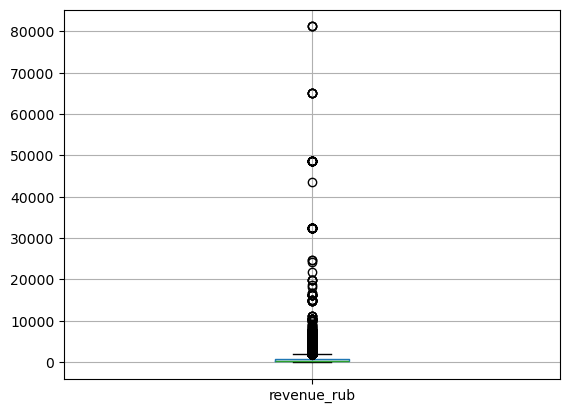

In [37]:
df[['user_id', 'revenue_rub']].boxplot()

В данных по суммарной выручке в рублях встречаются отрицательные значения, а также присутствуют выбросы

In [38]:
#Проводим фильтрацию по верхней и нижней границе
upper_limit = df['revenue_rub'].quantile(0.99)

df = df[df['revenue_rub'] <= upper_limit]

df = df[df['revenue_rub'] > 0]

In [39]:
df['revenue_rub'].describe()

count    281879.000000
mean        528.888310
std         511.717246
min           0.020000
25%         122.690000
50%         358.290000
75%         798.070000
max        2628.421739
Name: revenue_rub, dtype: float64

In [40]:
df[['user_id', 'revenue_rub']].boxplot()

<Axes: >

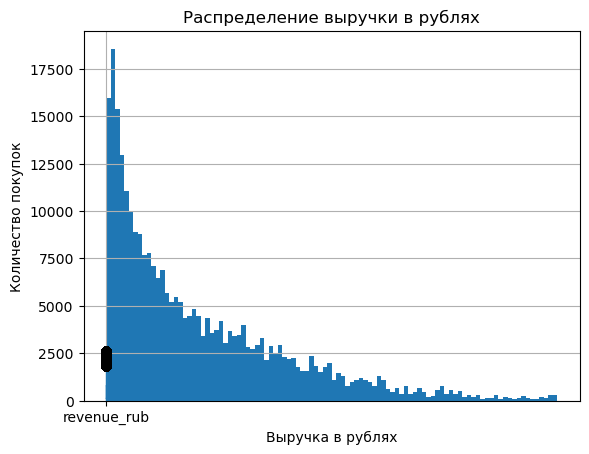

In [41]:
df['revenue_rub'].hist(bins=100)
plt.xlabel('Выручка в рублях')
plt.ylabel('Количество покупок')
plt.title('Распределение выручки в рублях')
plt.show()

In [42]:
df['tickets_count'].describe()

count    281879.000000
mean          2.744117
std           1.157190
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max          47.000000
Name: tickets_count, dtype: float64

In [43]:
df[['user_id', 'tickets_count']].boxplot()

<Axes: >

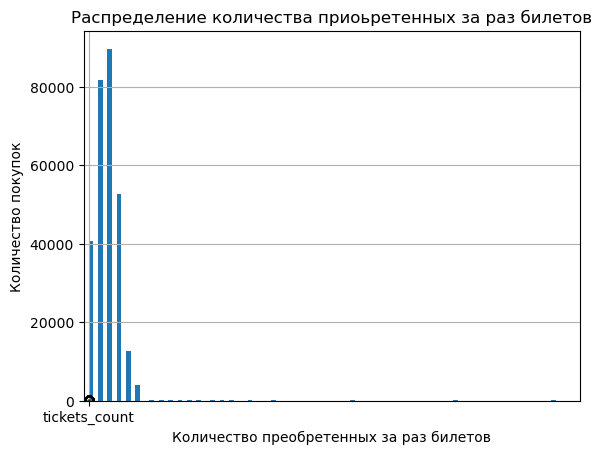

In [44]:
df['tickets_count'].hist(bins=100)
plt.xlabel('Количество преобретенных за раз билетов')
plt.ylabel('Количество покупок')
plt.title('Распределение количества приоьретенных за раз билетов')
plt.show()

Поле `tickets_count` также содержит выбросы, основная масса значений (до 75%) сосредоточена в пределах от 1 до 3 билетов. Данное поле в фильтрации не нуждается, т.к. выбросы не влияют на статистические показатели.

In [45]:
#Данные были отфильтрованы в следующем относительном значении и абсолютном:
print('Относительное количество:', (len(temp) - len(df)) / len(temp))
print('Абсолютное количество:', len(temp) - len(df))

Относительное количество: 0.03004703882509609
Абсолютное количество: 8732


**Промежуточный вывод:**
В предобработке данных было выполнено следующее: 
 - добавлен новый столбец `revenue_rub`, обозначающий суммарную выручку в рублях;
 - преобразованы типы данных int и float до минимально возможных по размеру в памяти
 - проверены значения категорий в номинальных данных, выполнена проверка на явные и неявные дубликаты
 - были проанализированы численные значения в полях `revenue_rub` и `tickets_count`.
 - датафрейм был отфильтрован по значению поля `revenue_rub` по 99% процентилю сверху и значениям выше нуля снизу.
В итоге была отфильтрована 14381 строка, что в относительном выражении - 0.05.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__
    
* В целом с задачей справились, предобработку провели!
    

</div>
<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__

    
* Сейчас ты фиксируешь общие выводы только в конце раздела. Чтобы в работе был понятный сторителлинг, стоит также фиксировать промежуточные свои наблюдения для каждого из шагов: почему мы ничего не стали делать с пропусками и перешли к следующему шагу? Как приняли решение скорректировать тип у тех или иных столбцов? Действительно ли наши категориальные признаки в порядке и не требуют нормализации? Действительно ли в числовых признаках есть выбросы, какова их предполагаемая природа возникновения? Почему мы решили отбросить выбросы в выручке? Почему решили не отбрасывать выбросы в количестве билетов?
    


    
</div>
<div class="alert alert-block alert-danger">✍
    

__Комментарий от ревьюера №1__


* В задании это не указывается, но по умолчанию важным шагом предварительного анализа и предобработки является проверка на наличие дубликатов, как полных, так и `неполных` (например, если заказ пользователя задублировался в системе, был создан в нескольких экземплярах с разным `id` и временем заказа). Чтобы не искажать статистические расчеты, от таких наблюдений тоже важно избавляться.
    

</div>

<div class="alert alert-info"> <b>Комментарии студента:</b> 

Понял, спасибо за замечание! Исправляю!

</div>

In [48]:
#Выполняем проверку на неявные дубликаты по id пользователя и id заказа
df.duplicated(subset=['user_id', 'order_id']).sum()

np.int64(0)

Неявных дубликатов по user_id и order_id не обнаружено.

Для проверки дубликтов заказов с разными order_id и временем заказа необходимо проверить, совпадают ли у таких заказов все остальные значения одновременно (разве что кроме значения в поле days_since_prev, т.к. при в дубликате будет 0)

In [50]:
df.duplicated(subset=['user_id', 'device_type_canonical', 'created_dt_msk', 'currency_code', 'revenue', 'tickets_count', 'event_id', 'event_name', 'event_type_main', 'service_name', 'region_name', 'city_name', 'revenue_rub']).sum()

np.int64(49098)

<div class="alert alert-info"> <b>Комментарии студента:</b> 

Такого результата я совсем неожидал. Целых 49 тысяч неявных дубликатов... Удаляем немедленно!

</div>

In [52]:
df = df.drop_duplicates(subset=['user_id', 'device_type_canonical', 'created_dt_msk', 'currency_code', 'revenue', 'tickets_count', 'event_id', 'event_name', 'event_type_main', 'service_name', 'region_name', 'city_name', 'revenue_rub'], keep='first')

In [53]:
#Данные были отфильтрованы в следующем относительном значении и абсолютном:
print('Относительное количество:', (len(temp) - len(df)) / len(temp))
print('Абсолютное количество:', len(temp) - len(df))

Относительное количество: 0.19899453220972366
Абсолютное количество: 57830


**Исправленный промежуточный вывод:** В предобработке данных было выполнено следующее:

 - добавлен новый столбец revenue_rub, обозначающий суммарную выручку в рублях;
 - преобразованы типы данных int и float до минимально возможных по размеру в памяти;
 - проверены значения категорий в номинальных данных, выполнена проверка на явные и неявные дубликаты;
 - были проанализированы численные значения в полях revenue_rub и tickets_count;
 - датафрейм был отфильтрован по значению поля revenue_rub по 99% процентилю сверху и значениям выше нуля снизу. В итоге было отфильтровано 57830 строк, что в относительном выражении - 0.19.

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [54]:
#Проводим сортировку по дате создания заказа
df = df.sort_values(by='created_dt_msk')

In [55]:
#Проверяем результат
df.head()

,user_id,device_type_canonical,order_id,created_dt_msk,created_ts_msk,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
68272,2f4d4a5cbde4602,mobile,1232472,2024-06-01,2024-06-01 13:16:18,rub,96.60,1,0.0,523759,7695e12c-ad15-4d15-84e0-2993db5a3f1d,концерты,Билеты в руки,Каменноярский край,Лесоярово,96.60
230337,c5663b19e202246,mobile,1576847,2024-06-01,2024-06-01 21:58:15,rub,763.03,4,NaN,352618,08a3f7af-ca1e-456f-935c-987ce8cd8be2,другое,Восьмёрка,Широковская область,Ягодиновка,763.03
78239,39942ba9c7367a8,mobile,4544562,2024-06-01,2024-06-01 12:38:24,rub,2005.63,5,NaN,284965,58574140-962c-49a3-af70-b773a05661a3,концерты,Билеты в руки,Малиновоярский округ,Верховино,2005.63
125787,60893c4e70271c0,desktop,7204297,2024-06-01,2024-06-01 07:03:10,rub,101.37,2,NaN,266160,782b5014-debe-4b5f-8f95-e0228a5f3155,театр,Тебе билет!,Светополянский округ,Глиноград,101.37
269891,ecd823cb1d28190,mobile,4334515,2024-06-01,2024-06-01 18:39:32,rub,35.89,3,NaN,501198,75f20014-54dd-4cb5-ad6e-8ceeed4fc324,другое,Билеты в руки,Заречная область,Дальнесветин,35.89


In [56]:
#Создаем профиль пользователя
user_list = df['user_id'].unique()
user_list

array(['2f4d4a5cbde4602', 'c5663b19e202246', '39942ba9c7367a8', ...,
       '1b2ff26e927a6aa', '316b6d1076e3fcd', '7c0f1cdb436ce17'],
      shape=(21700,), dtype=object)

In [57]:
user = pd.DataFrame()

In [58]:
user['user_id'] = user_list
user

,user_id
0,2f4d4a5cbde4602
1,c5663b19e202246
2,39942ba9c7367a8
3,60893c4e70271c0
4,ecd823cb1d28190
...,...
21695,a2f0c55b9781d1a
21696,7c1908cb4b166c1
21697,1b2ff26e927a6aa
21698,316b6d1076e3fcd


In [59]:
first_order = df.groupby('user_id')['created_dt_msk'].min().reset_index()
first_order.columns = ['user_id', 'first_order_date']
first_order

,user_id,first_order_date
0,0002849b70a3ce2,2024-08-20
1,0005ca5e93f2cf4,2024-07-23
2,000898990054619,2024-07-13
3,00096d1f542ab2b,2024-08-15
4,000a55a418c128c,2024-09-29
...,...,...
21695,fff13b79bd47d7c,2024-07-16
21696,fff32fc9ad0f9f6,2024-08-15
21697,fffcd3dde79eb2c,2024-06-20
21698,fffeeb3c120cf0b,2024-09-24


In [60]:
last_order = df.groupby('user_id')['created_dt_msk'].max().reset_index()
last_order.columns = ['user_id', 'last_order_date']
last_order

,user_id,last_order_date
0,0002849b70a3ce2,2024-08-20
1,0005ca5e93f2cf4,2024-10-06
2,000898990054619,2024-10-23
3,00096d1f542ab2b,2024-08-15
4,000a55a418c128c,2024-10-15
...,...,...
21695,fff13b79bd47d7c,2024-10-31
21696,fff32fc9ad0f9f6,2024-10-28
21697,fffcd3dde79eb2c,2024-10-30
21698,fffeeb3c120cf0b,2024-09-24


In [61]:
user_profile = pd.merge(user, first_order, on='user_id', how='left')
user_profile = pd.merge(user_profile, last_order, on='user_id', how='left')
user_profile

,user_id,first_order_date,last_order_date
0,2f4d4a5cbde4602,2024-06-01,2024-07-12
1,c5663b19e202246,2024-06-01,2024-10-12
2,39942ba9c7367a8,2024-06-01,2024-10-29
3,60893c4e70271c0,2024-06-01,2024-10-30
4,ecd823cb1d28190,2024-06-01,2024-10-31
...,...,...,...
21695,a2f0c55b9781d1a,2024-10-31,2024-10-31
21696,7c1908cb4b166c1,2024-10-31,2024-10-31
21697,1b2ff26e927a6aa,2024-10-31,2024-10-31
21698,316b6d1076e3fcd,2024-10-31,2024-10-31


In [62]:
first_order_region = df.groupby('user_id')[['device_type_canonical', 'region_name', 'service_name', 'event_type_main']].first().reset_index()
first_order_region.columns = ['user_id', 'first_device', 'first_order_region', 'first_order_service', 'first_order_event']
first_order_region

,user_id,first_device,first_order_region,first_order_service,first_order_event
0,0002849b70a3ce2,mobile,Каменевский регион,Край билетов,театр
1,0005ca5e93f2cf4,mobile,Каменевский регион,Мой билет,выставки
2,000898990054619,mobile,Североярская область,Лови билет!,другое
3,00096d1f542ab2b,desktop,Каменевский регион,Край билетов,театр
4,000a55a418c128c,mobile,Поленовский край,Лучшие билеты,театр
...,...,...,...,...,...
21695,fff13b79bd47d7c,mobile,Каменевский регион,Мой билет,другое
21696,fff32fc9ad0f9f6,desktop,Каменевский регион,Билеты без проблем,стендап
21697,fffcd3dde79eb2c,desktop,Каменевский регион,Билеты без проблем,концерты
21698,fffeeb3c120cf0b,desktop,Широковская область,Билеты без проблем,стендап


In [63]:
user_profile = pd.merge(user_profile, first_order_region, on='user_id', how='left')
user_profile

,user_id,first_order_date,last_order_date,first_device,first_order_region,first_order_service,first_order_event
0,2f4d4a5cbde4602,2024-06-01,2024-07-12,mobile,Каменноярский край,Билеты в руки,концерты
1,c5663b19e202246,2024-06-01,2024-10-12,mobile,Широковская область,Восьмёрка,другое
2,39942ba9c7367a8,2024-06-01,2024-10-29,mobile,Малиновоярский округ,Билеты в руки,концерты
3,60893c4e70271c0,2024-06-01,2024-10-30,desktop,Светополянский округ,Тебе билет!,театр
4,ecd823cb1d28190,2024-06-01,2024-10-31,mobile,Заречная область,Билеты в руки,другое
...,...,...,...,...,...,...,...
21695,a2f0c55b9781d1a,2024-10-31,2024-10-31,desktop,Каменевский регион,Мой билет,концерты
21696,7c1908cb4b166c1,2024-10-31,2024-10-31,mobile,Каменевский регион,Мой билет,концерты
21697,1b2ff26e927a6aa,2024-10-31,2024-10-31,mobile,Каменевский регион,Мой билет,концерты
21698,316b6d1076e3fcd,2024-10-31,2024-10-31,mobile,Речиновская область,Лови билет!,другое


In [64]:
summary_data = df.groupby('user_id').agg({'order_id':'count', 'revenue_rub':'mean', 'tickets_count':'mean'}).reset_index()
summary_data.columns = ['user_id', 'total_orders', 'mean_revenue', 'mean_order_tickets']
summary_data

,user_id,total_orders,mean_revenue,mean_order_tickets
0,0002849b70a3ce2,1,1521.940000,4.000000
1,0005ca5e93f2cf4,2,774.010000,3.000000
2,000898990054619,3,767.213333,2.666667
3,00096d1f542ab2b,1,917.830000,4.000000
4,000a55a418c128c,2,61.310000,1.500000
...,...,...,...,...
21695,fff13b79bd47d7c,7,621.661429,2.714286
21696,fff32fc9ad0f9f6,2,850.995000,2.500000
21697,fffcd3dde79eb2c,25,589.893600,2.680000
21698,fffeeb3c120cf0b,1,661.530000,2.000000


In [65]:
user_profile = pd.merge(user_profile, summary_data, on='user_id', how='left')
user_profile

,user_id,first_order_date,last_order_date,first_device,first_order_region,first_order_service,first_order_event,total_orders,mean_revenue,mean_order_tickets
0,2f4d4a5cbde4602,2024-06-01,2024-07-12,mobile,Каменноярский край,Билеты в руки,концерты,4,334.037500,2.250000
1,c5663b19e202246,2024-06-01,2024-10-12,mobile,Широковская область,Восьмёрка,другое,8,665.938750,3.375000
2,39942ba9c7367a8,2024-06-01,2024-10-29,mobile,Малиновоярский округ,Билеты в руки,концерты,24,570.352500,2.625000
3,60893c4e70271c0,2024-06-01,2024-10-30,desktop,Светополянский округ,Тебе билет!,театр,67,607.321642,2.447761
4,ecd823cb1d28190,2024-06-01,2024-10-31,mobile,Заречная область,Билеты в руки,другое,54,517.753889,2.425926
...,...,...,...,...,...,...,...,...,...,...
21695,a2f0c55b9781d1a,2024-10-31,2024-10-31,desktop,Каменевский регион,Мой билет,концерты,4,276.357500,2.000000
21696,7c1908cb4b166c1,2024-10-31,2024-10-31,mobile,Каменевский регион,Мой билет,концерты,1,80.620000,1.000000
21697,1b2ff26e927a6aa,2024-10-31,2024-10-31,mobile,Каменевский регион,Мой билет,концерты,1,80.620000,1.000000
21698,316b6d1076e3fcd,2024-10-31,2024-10-31,mobile,Речиновская область,Лови билет!,другое,2,52.335000,4.500000


In [66]:
df_sorted = df.sort_values(by=['user_id', 'created_dt_msk'])

# Рассчитываем разницу во времени между последовательными заказами
df_sorted['time_diff'] = df_sorted.groupby('user_id')['created_dt_msk'].diff().dt.days

mean_order_days = df_sorted.groupby('user_id')['time_diff'].mean().reset_index()
mean_order_days.columns = ['user_id', 'mean_order_days']
mean_order_days

,user_id,mean_order_days
0,0002849b70a3ce2,NaN
1,0005ca5e93f2cf4,75.000000
2,000898990054619,51.000000
3,00096d1f542ab2b,NaN
4,000a55a418c128c,16.000000
...,...,...
21695,fff13b79bd47d7c,17.833333
21696,fff32fc9ad0f9f6,74.000000
21697,fffcd3dde79eb2c,5.500000
21698,fffeeb3c120cf0b,NaN


In [67]:
user_profile = pd.merge(user_profile, mean_order_days, on='user_id', how='left')
user_profile

,user_id,first_order_date,last_order_date,first_device,first_order_region,first_order_service,first_order_event,total_orders,mean_revenue,mean_order_tickets,mean_order_days
0,2f4d4a5cbde4602,2024-06-01,2024-07-12,mobile,Каменноярский край,Билеты в руки,концерты,4,334.037500,2.250000,13.666667
1,c5663b19e202246,2024-06-01,2024-10-12,mobile,Широковская область,Восьмёрка,другое,8,665.938750,3.375000,19.000000
2,39942ba9c7367a8,2024-06-01,2024-10-29,mobile,Малиновоярский округ,Билеты в руки,концерты,24,570.352500,2.625000,6.521739
3,60893c4e70271c0,2024-06-01,2024-10-30,desktop,Светополянский округ,Тебе билет!,театр,67,607.321642,2.447761,2.287879
4,ecd823cb1d28190,2024-06-01,2024-10-31,mobile,Заречная область,Билеты в руки,другое,54,517.753889,2.425926,2.867925
...,...,...,...,...,...,...,...,...,...,...,...
21695,a2f0c55b9781d1a,2024-10-31,2024-10-31,desktop,Каменевский регион,Мой билет,концерты,4,276.357500,2.000000,0.000000
21696,7c1908cb4b166c1,2024-10-31,2024-10-31,mobile,Каменевский регион,Мой билет,концерты,1,80.620000,1.000000,NaN
21697,1b2ff26e927a6aa,2024-10-31,2024-10-31,mobile,Каменевский регион,Мой билет,концерты,1,80.620000,1.000000,NaN
21698,316b6d1076e3fcd,2024-10-31,2024-10-31,mobile,Речиновская область,Лови билет!,другое,2,52.335000,4.500000,0.000000


In [68]:
def is_two(row):
    if row['total_orders'] >= 2:
        row['is_two'] = 1
    else:
        row['is_two'] = 0
    return row

In [69]:
def is_five(row):
    if row['total_orders'] >= 5:
        row['is_five'] = 1
    else:
        row['is_five'] = 0
    return row

In [70]:
user_profile = user_profile.apply(is_two, axis=1)

In [71]:
user_profile = user_profile.apply(is_five, axis=1)

In [72]:
user_profile

,user_id,first_order_date,last_order_date,first_device,first_order_region,first_order_service,first_order_event,total_orders,mean_revenue,mean_order_tickets,mean_order_days,is_two,is_five
0,2f4d4a5cbde4602,2024-06-01,2024-07-12,mobile,Каменноярский край,Билеты в руки,концерты,4,334.037500,2.250000,13.666667,1,0
1,c5663b19e202246,2024-06-01,2024-10-12,mobile,Широковская область,Восьмёрка,другое,8,665.938750,3.375000,19.000000,1,1
2,39942ba9c7367a8,2024-06-01,2024-10-29,mobile,Малиновоярский округ,Билеты в руки,концерты,24,570.352500,2.625000,6.521739,1,1
3,60893c4e70271c0,2024-06-01,2024-10-30,desktop,Светополянский округ,Тебе билет!,театр,67,607.321642,2.447761,2.287879,1,1
4,ecd823cb1d28190,2024-06-01,2024-10-31,mobile,Заречная область,Билеты в руки,другое,54,517.753889,2.425926,2.867925,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21695,a2f0c55b9781d1a,2024-10-31,2024-10-31,desktop,Каменевский регион,Мой билет,концерты,4,276.357500,2.000000,0.000000,1,0
21696,7c1908cb4b166c1,2024-10-31,2024-10-31,mobile,Каменевский регион,Мой билет,концерты,1,80.620000,1.000000,NaN,0,0
21697,1b2ff26e927a6aa,2024-10-31,2024-10-31,mobile,Каменевский регион,Мой билет,концерты,1,80.620000,1.000000,NaN,0,0
21698,316b6d1076e3fcd,2024-10-31,2024-10-31,mobile,Речиновская область,Лови билет!,другое,2,52.335000,4.500000,0.000000,1,0


In [73]:
temp2 = len(user_profile)
temp2

21700

<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__
    
* Также есть довольно удобный метод [assign](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.assign.html), позволяющий дополнять таблицу новыми рассчитанными столбцами.
    
    Тогда создание всего профиля можно будет записать красивым и удобным по структуре кодом.

    <details> <summary> <span style='color:blue' > Развернуть подробнее. </span> </summary>

    ```python
    profiles = (df
            # В начале сортируем данные по дате совершения заказа, что найти первые признаки:
            .sort_values(by='order_ts')
            # Затем группируем по номеру пользователя и агрегируем данные:
            .groupby('user_id')
            .agg(
                # Находим первую и последнюю даты заказа:
                first_order_dt=('order_dt','min'),
                last_order_dt=('order_dt','max'),
                # Находим устройства, регион, название билетного партнера и тип мероприятия первого заказа:
                first_device=('device_type_canonical','first'),
                first_region_name=('region_name','first'),
                first_service_name=('service_name','first'),
                first_event_type=('event_type_main','first'),
                # Подсчитваем количество заказов:
                total_orders=('order_id','nunique'),
                # Считаем статистику по заказам: средняя стоимость заказа, среднее количество билетов:
                avg_revenue_rub=('revenue_rub','mean'),
                avg_tickets_count=('tickets_count','mean'),
                # Считаем среднее количество дней между покупками:
                avg_days_since_prev=('days_since_prev','mean')
            )
            # Создаем два признака: совершил ли пользователь 2 / 5 и более заказов:
            .assign(
                is_two = lambda x: x['total_orders'] >= 2,
                is_five = lambda x: x['total_orders'] >= 5
            )
            .reset_index()
    )
    ```
    </details>

    

    
</div>

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [74]:
#Общее число пользователей в выборке
user_profile['user_id'].count()

np.int64(21700)

In [75]:
user_profile.shape[0]

21700

In [76]:
#Средняя выручка с одного заказа
user_profile['mean_revenue'].mean()

np.float64(551.8577268051428)

In [77]:
#Доля пользователей 2 и более заказа
user_profile['is_two'].sum() / user_profile.shape[0]

np.float64(0.5920276497695852)

In [78]:
#Доля пользователей 5 и более заказов
user_profile['is_five'].sum() / user_profile.shape[0]

np.float64(0.2483410138248848)

In [79]:
#Статистические данные по общему количеству заказов
user_profile['total_orders'].describe()

count    21700.000000
mean        10.727235
std        100.128428
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max       8556.000000
Name: total_orders, dtype: float64

В данных общего количества заказов явно присутствуют выбросы. Их необходимо отфильтровать, т.к. целевой аудиторией являются люди с небольшим количеством заказов. Попробуем отфильтровать сначала по 99 процентилю

In [80]:
#Фильтруем по 99 процентилю
max_value = user_profile['total_orders'].quantile(0.99)
user_profile = user_profile[user_profile['total_orders'] <= max_value]

In [81]:
#Снова смотрим статистику
user_profile['total_orders'].describe()

count    21484.000000
mean         5.287470
std         11.143002
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        123.000000
Name: total_orders, dtype: float64

Максимальное значение стало меньше, однако всё равно ещё во много раз больше всех остальных и сильно влияет на статистические показатели. Отфильтруем по 95 процентилю

In [82]:
#Фильтруем по 95 процентилю
max_value = user_profile['total_orders'].quantile(0.95)
user_profile = user_profile[user_profile['total_orders'] <= max_value]

In [83]:
#Снова смотрим статистику
user_profile['total_orders'].describe()

count    20449.000000
mean         3.233165
std          3.609931
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         21.000000
Name: total_orders, dtype: float64

Теперь максимальное значение не так сильно удалено от всех остальных и не сильно влияет на статистику.

In [84]:
#Статистические данные по среднему числу билетов в заказе
user_profile['mean_order_tickets'].describe()

count    20449.000000
mean         2.746850
std          0.934262
min          1.000000
25%          2.000000
50%          2.750000
75%          3.142857
max         11.000000
Name: mean_order_tickets, dtype: float64

Данные без выбросов

In [85]:
#Статистические данные по среднему количеству дней между покупками
user_profile['mean_order_days'].describe()

count    11596.000000
mean        19.920850
std         24.087435
min          0.000000
25%          3.000000
50%         12.500000
75%         26.666667
max        148.000000
Name: mean_order_days, dtype: float64

В этих данных есть выросы, однако их необходимо оставить, поскольку нам важен каждый пользователь - вне зависимости от того, когда он вернулся за новым заказом.

In [86]:
#Итоги фильтрации
print('Отфильтровано строк:', temp2 - user_profile.shape[0])
print('Относительная величина фильтрации:', (temp2 - user_profile.shape[0]) / temp2)

Отфильтровано строк: 1251
Относительная величина фильтрации: 0.05764976958525345


**Общий промежуточный вывод**

Данных достаточно по объему, они репрезентативны. Аномалии были выявлены в общем количестве заказов и среднем количестве дней между заказами. В первом случае данные были отфильтрованы по 95 процентилю, так как искажали статистику и не отражали целевую аудиторию, во втором - принято решение оставить их, т.к. важен каждый пользователь, независимо от того, через сколько дней он вернулся за заказом.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

    
Здесь  все супер, выполнены все необходимые шаги! 
    
    
Как рекомендация, было бы не лишним также проверить, насколько изменилась средняя выручка после удаления выбросов. Посмотреть на распределение данных с помощью гистограмм и диаграмм размаха.    
    
    
Так же, хорошо было бы лучше сначала обосновать выбор стратегии по обработке, а потом уже приступить к ее выполнению при необходимости.    

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [87]:
#Выводим абсолютное количество пользователей в категориях
user_profile.groupby('first_order_event')['user_id'].count()

first_order_event
выставки     398
другое      4966
концерты    9133
спорт        748
стендап     1078
театр       4037
ёлки          89
Name: user_id, dtype: int64

In [88]:
#Выводим долю пользователей по категориям
user_profile.groupby('first_order_event')['user_id'].count() / user_profile.shape[0]

first_order_event
выставки    0.019463
другое      0.242848
концерты    0.446623
спорт       0.036579
стендап     0.052717
театр       0.197418
ёлки        0.004352
Name: user_id, dtype: float64

In [89]:
#Выводим абсолютное количество пользователей в категориях
user_profile.groupby('first_device')['user_id'].count()

first_device
desktop     3491
mobile     16958
Name: user_id, dtype: int64

In [90]:
#Выводим долю пользователей по категориям
user_profile.groupby('first_device')['user_id'].count() / user_profile.shape[0]

first_device
desktop    0.170717
mobile     0.829283
Name: user_id, dtype: float64

In [91]:
#Выводим абсолютное количество пользователей в категориях
user_profile.groupby('first_order_region')['user_id'].count().sort_values()

first_order_region
Яснопольский округ             1
Сосноводолинская область       1
Верхозёрский край              1
Светолесский край              1
Верховинская область           2
                            ... 
Малиновоярский округ         514
Озернинский край             661
Широковская область         1188
Североярская область        3577
Каменевский регион          6626
Name: user_id, Length: 81, dtype: int64

In [92]:
#Выводим долю пользователей по категориям
user_profile.groupby('first_order_region')['user_id'].count().sort_values() / user_profile.shape[0]

first_order_region
Яснопольский округ          0.000049
Сосноводолинская область    0.000049
Верхозёрский край           0.000049
Светолесский край           0.000049
Верховинская область        0.000098
                              ...   
Малиновоярский округ        0.025136
Озернинский край            0.032324
Широковская область         0.058096
Североярская область        0.174923
Каменевский регион          0.324026
Name: user_id, Length: 81, dtype: float64

In [93]:
#Выводим абсолютное количество пользователей в категориях
user_profile.groupby('first_order_service')['user_id'].count().sort_values()

first_order_service
Зе Бест!                     1
Лимоны                       2
Тех билет                    3
Билет по телефону            6
Вперёд!                      7
Кино билет                   9
КарандашРУ                  14
Шоу начинается!             18
Цвет и билет                21
Телебилет                   27
Реестр                      27
Радио ticket                35
Росбилет                    38
Crazy ticket!               45
Быстрый кассир              52
Восьмёрка                   86
Выступления.ру              94
Show_ticket                154
Быстробилет                158
Мир касс                   194
За билетом!                199
Городской дом культуры     208
Тебе билет!                298
Яблоко                     309
Дом культуры               331
Край билетов               437
Прачечная                  550
Лучшие билеты             1129
Весь в билетах            1223
Облачко                   2121
Билеты в руки             2406
Лови билет!        

In [94]:
#Выводим долю пользователей по категориям
user_profile.groupby('first_order_service')['user_id'].count().sort_values() / user_profile.shape[0]

first_order_service
Зе Бест!                  0.000049
Лимоны                    0.000098
Тех билет                 0.000147
Билет по телефону         0.000293
Вперёд!                   0.000342
Кино билет                0.000440
КарандашРУ                0.000685
Шоу начинается!           0.000880
Цвет и билет              0.001027
Телебилет                 0.001320
Реестр                    0.001320
Радио ticket              0.001712
Росбилет                  0.001858
Crazy ticket!             0.002201
Быстрый кассир            0.002543
Восьмёрка                 0.004206
Выступления.ру            0.004597
Show_ticket               0.007531
Быстробилет               0.007727
Мир касс                  0.009487
За билетом!               0.009732
Городской дом культуры    0.010172
Тебе билет!               0.014573
Яблоко                    0.015111
Дом культуры              0.016187
Край билетов              0.021370
Прачечная                 0.026896
Лучшие билеты             0.055211


**Промежуточный вывод**

Пользователи распределены по серментам неравномерно, присутствуют, так называемые, "точки входа". Например: по типу мероприятия больше всего пользователей купили билеты на `концентры`, `другое` и `театр`; по устройству - абсолютный лидер `mobile`; по региону первого заказа больше всего выделяются `Широковская область`,`Североярская область` и `Каменевский регион`; по оператору первого заказа можно выделить топ-5 операторов: `Облачко`, `Билеты в руки`, `Лови билет!`, `Мой билет` и `Билеты без проблем`.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

По результатам всё верно
    
    
<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__
    
* Можно создать пользовательскую функцию, чтобы не прописывать практически один и тот же код несколько раз  
    
        def segment_summary(df, column):
        seg = (df.groupby(column).agg(users_count=('user_id', 'nunique')) .reset_index().sort_values('users_count', ascending=False))
        seg['users_share'] = (seg['users_count'] / seg['users_count'].sum() *100)
        seg['users_share'] = seg['users_share'].round(2)
        return seg

    
* Визуализировать полученные данные,   
    
* По выводам хорошо бы показать общую картину: как распределяются пользователи по сегментам, какие группы преобладают, какие встречаются реже и почему так может быть. А уже после этого привести конкретные значения - как подтверждение своих наблюдений.  

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [95]:
#Доля 2 и более заказов для мероприятия
is_two_event = user_profile.groupby('first_order_event')['is_two'].sum() / user_profile.groupby('first_order_event')['user_id'].count()
is_two_event = is_two_event.sort_values()
is_two_event

first_order_event
спорт       0.505348
ёлки        0.516854
другое      0.549537
стендап     0.569573
концерты    0.570240
театр       0.589547
выставки    0.605528
dtype: float64

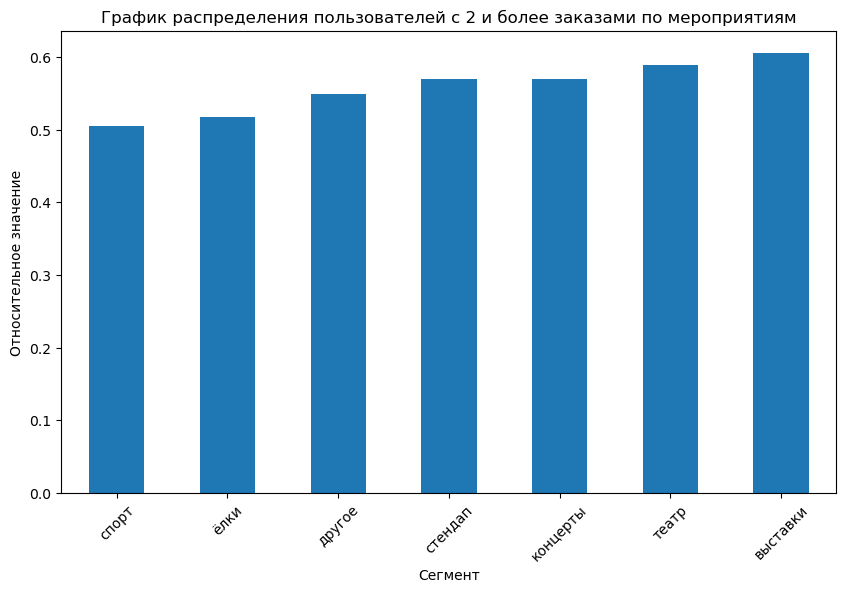

In [96]:
#Визуализируем
is_two_event.plot(kind='bar', rot=45, figsize=(10, 6))
plt.xlabel('Сегмент')
plt.ylabel('Относительное значение')
plt.title('График распределения пользователей с 2 и более заказами по мероприятиям')
plt.show()

In [97]:
#Доля 2 и более заказов для устройства
is_two_device = user_profile.groupby('first_device')['is_two'].sum() / user_profile.groupby('first_device')['user_id'].count()
is_two_device = is_two_device.sort_values()
is_two_device

first_device
mobile     0.562036
desktop    0.591521
dtype: float64

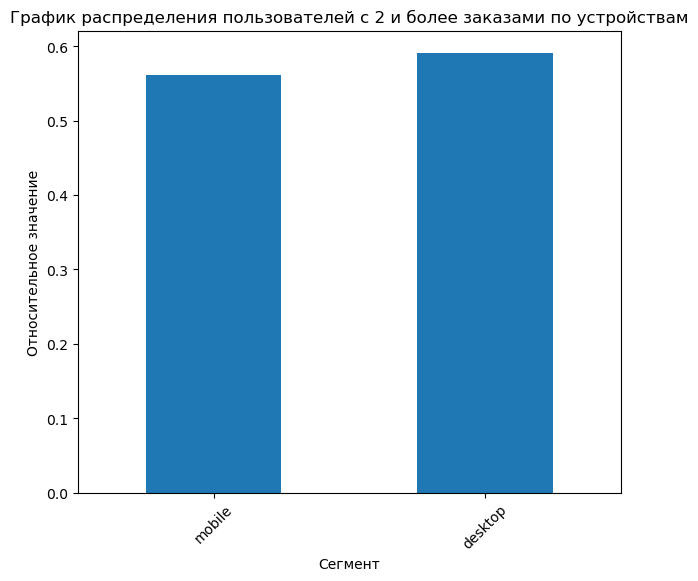

In [98]:
#Визуализируем
is_two_device.plot(kind='bar', rot=45, figsize=(7, 6))
plt.xlabel('Сегмент')
plt.ylabel('Относительное значение')
plt.title('График распределения пользователей с 2 и более заказами по устройствам')
plt.show()

In [99]:
#Доля 2 и более заказов для региона
is_two_region = user_profile.groupby('first_order_region')['is_two'].sum() / user_profile.groupby('first_order_region')['user_id'].count()
is_two_region = is_two_region.sort_values()
is_two_region

first_order_region
Яснопольский округ          0.000000
Крутоводский регион         0.000000
Сосноводолинская область    0.000000
Светолесский край           0.000000
Островогорский округ        0.000000
                              ...   
Лесноярский край            0.666667
Радужнопольский край        0.714286
Тихолесский край            0.727273
Озернопольская область      0.884615
Верхозёрский край           1.000000
Length: 81, dtype: float64

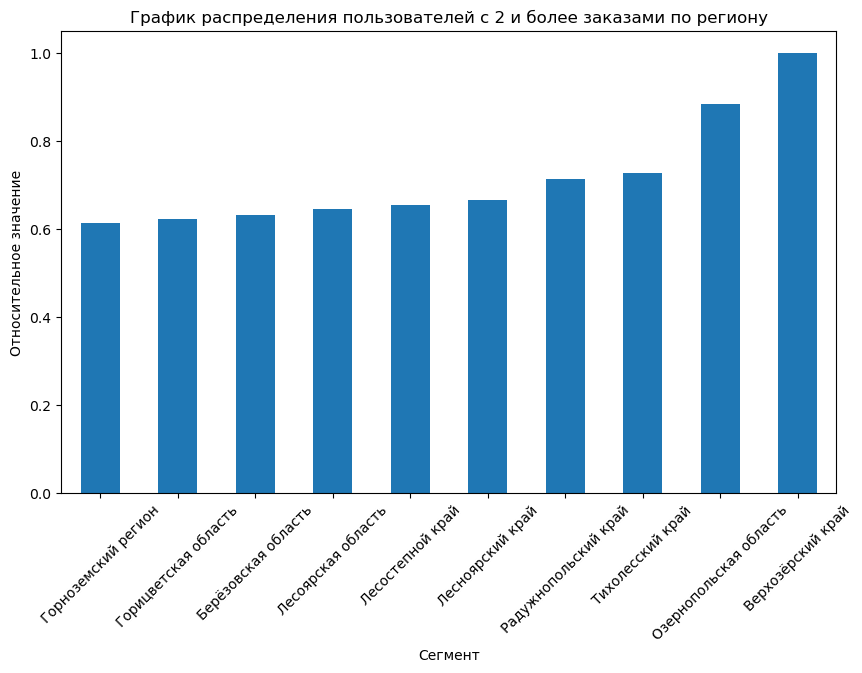

In [100]:
#Визуализируем
is_two_region_10 = is_two_region.tail(10)
is_two_region_10.plot(kind='bar', rot=45, figsize=(10, 6))
plt.xlabel('Сегмент')
plt.ylabel('Относительное значение')
plt.title('График распределения пользователей с 2 и более заказами по региону')
plt.show()

In [101]:
#Доля 2 и более заказов для билетного оператора
is_two_service = user_profile.groupby('first_order_service')['is_two'].sum() / user_profile.groupby('first_order_service')['user_id'].count()
is_two_service = is_two_service.sort_values()
is_two_service

first_order_service
Шоу начинается!           0.222222
Тех билет                 0.333333
КарандашРУ                0.357143
Радио ticket              0.400000
Телебилет                 0.407407
Вперёд!                   0.428571
Лимоны                    0.500000
Яблоко                    0.504854
Тебе билет!               0.550336
Городской дом культуры    0.552885
Билеты без проблем        0.554311
Кино билет                0.555556
Лучшие билеты             0.561559
Мой билет                 0.562259
За билетом!               0.562814
Быстробилет               0.563291
Выступления.ру            0.563830
Лови билет!               0.564940
Облачко                   0.569543
Прачечная                 0.576364
Весь в билетах            0.578904
Билеты в руки             0.581463
Мир касс                  0.582474
Дом культуры              0.583082
Show_ticket               0.603896
Росбилет                  0.605263
Цвет и билет              0.619048
Край билетов              0.624714


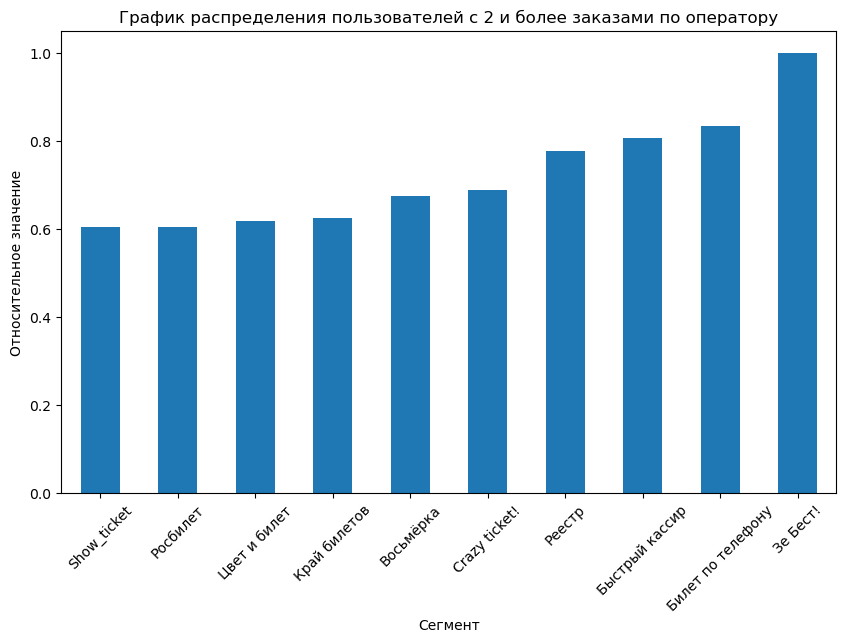

In [102]:
#Визуализируем
is_two_service_10 = is_two_service.tail(10)
is_two_service_10.plot(kind='bar', rot=45, figsize=(10, 6))
plt.xlabel('Сегмент')
plt.ylabel('Относительное значение')
plt.title('График распределения пользователей с 2 и более заказами по оператору')
plt.show()

**Вывод**

Чаще возвращаются пользователи, купившие в первый раз билет на выставки, совершившие первый заказ с компьютера, из Верхнеозерского края и пользующиеся оператором "Зе Бест!".

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__
 
    
* Можно было бы еще сделать более яркий акцент на том, что в топ по повторным заказам вырвались регионы с ощутимо меньшим числом пользователей, а значит оценка показателя возвращаемости у них более чувствительна к колебаниям в количестве пользователей (1 дополнительный пользователь может существеннее повлиять на показатель, как в плюс, так и в минус).

</div>
<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__


    
* В случае вывода неполного набора сегментов стоит указать, какой процент от выборки они составляют, чтобы было понимание, насколько большая часть данных осталась за пределами нашего обзора.
    
   
    
    
* Также было бы неплохо добавить на графики линию среднего значения, чтобы было удобно сравнивать, какие сегменты и насколько отличаются от общего показателя по выборке. Это можно сделать с помощью `plt.axvline`, потребуется также добавить легенду.
    

* Выводы лучше подкреплять конкретными значениями (в данном случае количеством и долей), чтобы явно отразить, насколько велики эффекты, о которых мы говорим.

</div>

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

**Выводы по гипотезе 1**

Распределение по мероприятию первого заказа при повторных заказах действительно есть, однако градация в относительной величине не так велика, относительные значения достаточно близко друг другу. Тем не менее выделить можно лидера - `выставки`. 

В случае же со спортивными мероприятиями и концертами гипотеза не подтверждается, пользователи, которые совершили первый заказ на спортивные мероприятия находятся в самом низу топа по возвращениям.

**Выводы по гипотезе 2**

Гипотеза не подтверждается. К примеру, регион-лидер по возвращениям находится в самом низу топа по общему количеству пользователей. Регионов-лидеров по количеству пользователей не наблюдается в топе регионов по возвращениям.

**Дополнение**

Также стоит отметить, что похожая ситуация (как с регионами) наблюдается и с операторами: оператор-лидер по числу вернувшихся клиентов находится в самом низу топа по общему количеству пользователей.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

По второй гипотезе можно сопоставить объем выборки с полученными результатом  

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


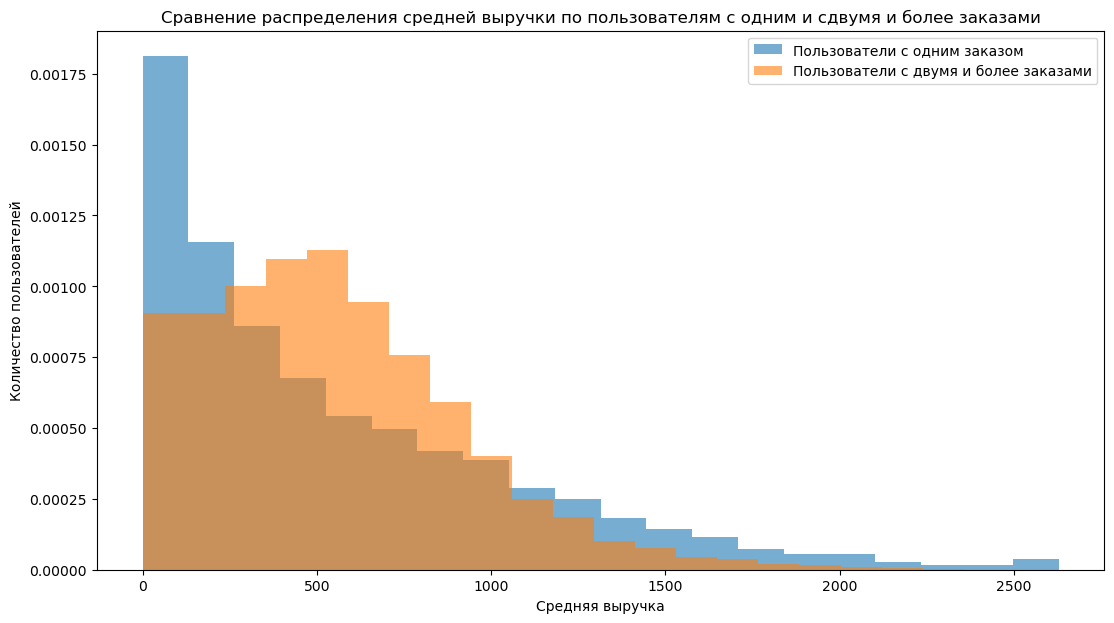

In [103]:
plt.figure(figsize=(13, 7))
one_order_users = user_profile[user_profile['is_two'] == 0]['mean_revenue']
two_order_users = user_profile[user_profile['is_two'] == 1]['mean_revenue']
plt.hist(one_order_users, bins=20, alpha=0.6, density=True, label='Пользователи с одним заказом')
plt.hist(two_order_users, bins=20, alpha=0.6, density=True, label='Пользователи с двумя и более заказами')
plt.xlabel('Средняя выручка')
plt.ylabel('Количество пользователей')
plt.title('Сравнение распределения средней выручки по пользователям с одним и сдвумя и более заказами')
plt.legend()
plt.show()

**Вывод**

Пользователи с одним заказом сконцентрированы в левой части графика около значений, близких к нулю.

Пользователи с двумя и более заказами сконцентрированы в области от 0 до примерно 750 рублей по средней выручке.

Из всего этого можно сделать вывод, что пользователи с более дорогими заказами более заинтересованы в сервисе.

<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__

Можно чуть структурировать интерпретацию. Начни с общего сравнения (чем отличаются группы в целом), затем подчеркни ключевые различия в диапазонах (например, что возвращающиеся чаще в зоне от...–до... ₽, а однократные имеют больший разброс), и завершай возможными причинами — например, что нулевая выручка у однократных, вероятно, связана с возвратами, а крупные заказы — с разовыми покупками для групп.
    
Еще можно добавить расчёты медины и среднего, чтобы понимать - имеется ли смещение и в какую сторону    

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


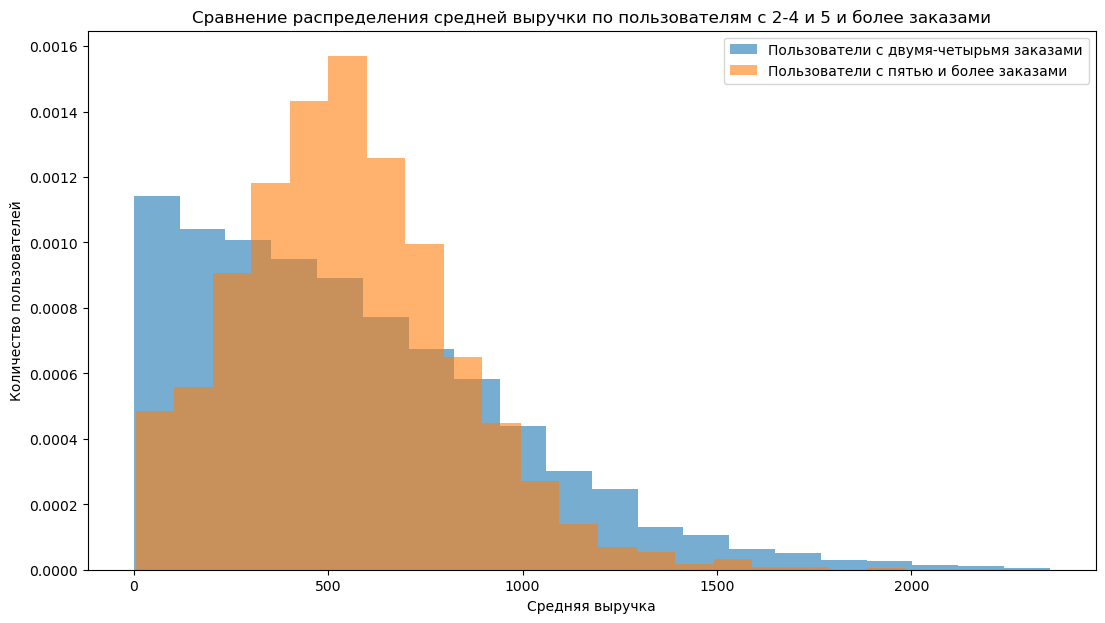

In [104]:
plt.figure(figsize=(13, 7))
two_order_users = user_profile[(user_profile['is_two'] == 1) & (user_profile['is_five'] == 0)]['mean_revenue']
five_order_users = user_profile[user_profile['is_five'] == 1]['mean_revenue']
plt.hist(two_order_users, bins=20, alpha=0.6, density=True, label='Пользователи с двумя-четырьмя заказами')
plt.hist(five_order_users, bins=20, alpha=0.6, density=True, label='Пользователи с пятью и более заказами')
plt.xlabel('Средняя выручка')
plt.ylabel('Количество пользователей')
plt.title('Сравнение распределения средней выручки по пользователям с 2-4 и 5 и более заказами')
plt.legend()
plt.show()

**Вывод**

Пользователи с 5 и более заказами имеют ярко выраженный пик около значения в 500 рублей средней выручки, в то же время пользователи с 2-4 заказами имеют максимум, близкий к нулю, а остальные значения по выручке далее представлены по нисходящей тенденции. Это снова подтверждает, что пользователи с более дорогими заказами более заинтересованы в возвращении на сервис.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

    
* С этой задачей тоже справились! 
    
 
* Плюс за грамотное оформление графиков - заголовок, подписи осей, легенда, поправка на размер выборки (`density`). По выводам тоже все верно подмечено!
 
</div>
<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__
    



    
* Чтобы удобно было сопоставлять доли пользователей по диапазонам цен, можно настроить единый размер бинов (`bins = 20` фиксирует количество бинов, но размер между сегментами будет отличаться, поскольку диапазон значений у них разный). Для этого в `bins` можно передать границы для формирования бинов с шагом: `bins = range(min_value, max_value+1, 50)`, максимальное и минимальное значения при этом определяем на всей выборке, а не отдельно для каждого сегмента.

</div>

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [105]:
#1-2 билета
one_two_tickets = user_profile[user_profile['mean_order_tickets'] < 2]['user_id'].count()
one_two_tickets_back = user_profile[user_profile['mean_order_tickets'] < 2]['is_two'].sum()
print('Общее число пользователей со средним количеством билетов в заказе от 1 до 2:', one_two_tickets)
print('Доля вернувшихся пользователей со средним количеством билетов в заказе от 1 до 2:', one_two_tickets_back / one_two_tickets)

Общее число пользователей со средним количеством билетов в заказе от 1 до 2: 2249
Доля вернувшихся пользователей со средним количеством билетов в заказе от 1 до 2: 0.44286349488661625


In [106]:
#2-3 билета
two_three_tickets = user_profile[(user_profile['mean_order_tickets'] >= 2) & (user_profile['mean_order_tickets'] < 3)]['user_id'].count()
two_three_tickets_back = user_profile[(user_profile['mean_order_tickets'] >= 2) & (user_profile['mean_order_tickets'] < 3)]['is_two'].sum()
print('Общее число пользователей со средним количеством билетов в заказе от 2 до 3:', two_three_tickets)
print('Доля вернувшихся пользователей со средним количеством билетов в заказе от 2 до 3:', two_three_tickets_back / two_three_tickets)

Общее число пользователей со средним количеством билетов в заказе от 2 до 3: 8570
Доля вернувшихся пользователей со средним количеством билетов в заказе от 2 до 3: 0.6903150525087515


In [107]:
#3-5 билетов
three_five_tickets = user_profile[(user_profile['mean_order_tickets'] >= 3) & (user_profile['mean_order_tickets'] < 5)]['user_id'].count()
three_five_tickets_back = user_profile[(user_profile['mean_order_tickets'] >= 3) & (user_profile['mean_order_tickets'] < 5)]['is_two'].sum()
print('Общее число пользователей со средним количеством билетов в заказе от 3 до 5:', three_five_tickets)
print('Доля вернувшихся пользователей со средним количеством билетов в заказе от 3 до 5:', three_five_tickets_back / three_five_tickets)

Общее число пользователей со средним количеством билетов в заказе от 3 до 5: 8970
Доля вернувшихся пользователей со средним количеством билетов в заказе от 3 до 5: 0.5114827201783724


In [108]:
#5 и более билетов
five_and_more_tickets = user_profile[user_profile['mean_order_tickets'] >= 5]['user_id'].count()
five_and_more_tickets_back = user_profile[user_profile['mean_order_tickets'] >= 5]['is_two'].sum()
print('Общее число пользователей со средним количеством билетов в заказе от 5 и выше:', five_and_more_tickets)
print('Доля вернувшихся пользователей со средним количеством билетов в заказе от 5 и выше:', five_and_more_tickets_back / five_and_more_tickets)

Общее число пользователей со средним количеством билетов в заказе от 5 и выше: 660
Доля вернувшихся пользователей со средним количеством билетов в заказе от 5 и выше: 0.14545454545454545


**Вывод**

Основная масса пользователей сосредоточена в сегментах `2-3 билета` и `3-5 билетов`, затем идет сегмент `1-2 билета` и меньше всего пользователей в сегменте `5 и более билетов`. 

При этом примерно одинаковые доли вернувшихся пользователей в сегментах `1-2 билета` и `3-5 билетов` (44 и 50%), аутсайдер - `5 и более билетов` (15%), самая высокая доля вернувшихся в сегменте `2-3 билета` (69%).

На основе этого можно сделать следующий вывод: объем заказа действительно влияет на возврат пользователя, но до определенной границы - в данном случае `2-3 билета`, большие объемы заказов меньше приводят к возврату пользователей.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Можно чуть развить вывод — предположить, почему пользователи, покупающие 2–3 билета, возвращаются чаще. Например, это могут быть небольшие компании или семьи, которые чаще ходят на мероприятия вместе, а значит, лояльность у них выше. А вот пользователи с 5+ билетами, вероятно, совершают разовые групповые покупки (например, для организации или класса), поэтому возвращаются реже

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [109]:
day_of_week_df = user_profile.copy()
day_of_week_df.head()

,user_id,first_order_date,last_order_date,first_device,first_order_region,first_order_service,first_order_event,total_orders,mean_revenue,mean_order_tickets,mean_order_days,is_two,is_five
0,2f4d4a5cbde4602,2024-06-01,2024-07-12,mobile,Каменноярский край,Билеты в руки,концерты,4,334.037500,2.250000,13.666667,1,0
1,c5663b19e202246,2024-06-01,2024-10-12,mobile,Широковская область,Восьмёрка,другое,8,665.938750,3.375000,19.000000,1,1
7,af619edc4a1d914,2024-06-01,2024-10-09,mobile,Каменевский регион,Билеты без проблем,концерты,12,777.588333,2.583333,11.818182,1,1
10,605252153ed7b2a,2024-06-01,2024-09-25,mobile,Заречная область,Билеты в руки,другое,4,43.525605,2.000000,38.666667,1,0
11,39cc557817fc4fe,2024-06-01,2024-10-18,mobile,Североярская область,Лови билет!,выставки,11,439.984545,2.545455,13.900000,1,1


In [110]:
day_of_week_df['day_of_week'] = day_of_week_df['first_order_date'].dt.day_name()

In [111]:
day_of_week_df.head()

,user_id,first_order_date,last_order_date,first_device,first_order_region,first_order_service,first_order_event,total_orders,mean_revenue,mean_order_tickets,mean_order_days,is_two,is_five,day_of_week
0,2f4d4a5cbde4602,2024-06-01,2024-07-12,mobile,Каменноярский край,Билеты в руки,концерты,4,334.037500,2.250000,13.666667,1,0,Saturday
1,c5663b19e202246,2024-06-01,2024-10-12,mobile,Широковская область,Восьмёрка,другое,8,665.938750,3.375000,19.000000,1,1,Saturday
7,af619edc4a1d914,2024-06-01,2024-10-09,mobile,Каменевский регион,Билеты без проблем,концерты,12,777.588333,2.583333,11.818182,1,1,Saturday
10,605252153ed7b2a,2024-06-01,2024-09-25,mobile,Заречная область,Билеты в руки,другое,4,43.525605,2.000000,38.666667,1,0,Saturday
11,39cc557817fc4fe,2024-06-01,2024-10-18,mobile,Североярская область,Лови билет!,выставки,11,439.984545,2.545455,13.900000,1,1,Saturday


In [112]:
days_amount = day_of_week_df.groupby('day_of_week')['user_id'].count()
days_amount

day_of_week
Friday       3118
Monday       2764
Saturday     3067
Sunday       2595
Thursday     2989
Tuesday      2992
Wednesday    2924
Name: user_id, dtype: int64

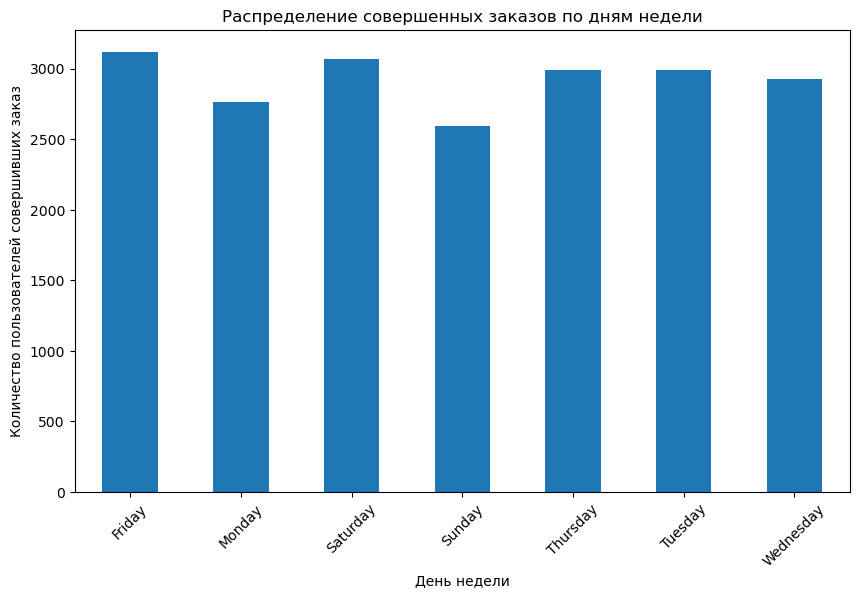

In [113]:
plt.figure(figsize=(10, 6))
days_amount.plot(kind='bar', rot=45)
plt.xlabel('День недели')
plt.ylabel('Количество пользователей совершивших заказ')
plt.title('Распределение совершенных заказов по дням недели')
plt.show()

In [114]:
days_amount_back = day_of_week_df.groupby('day_of_week')['is_two'].sum() / days_amount
days_amount_back

day_of_week
Friday       0.559012
Monday       0.581042
Saturday     0.576785
Sunday       0.553372
Thursday     0.551020
Tuesday      0.566845
Wednesday    0.581053
dtype: float64

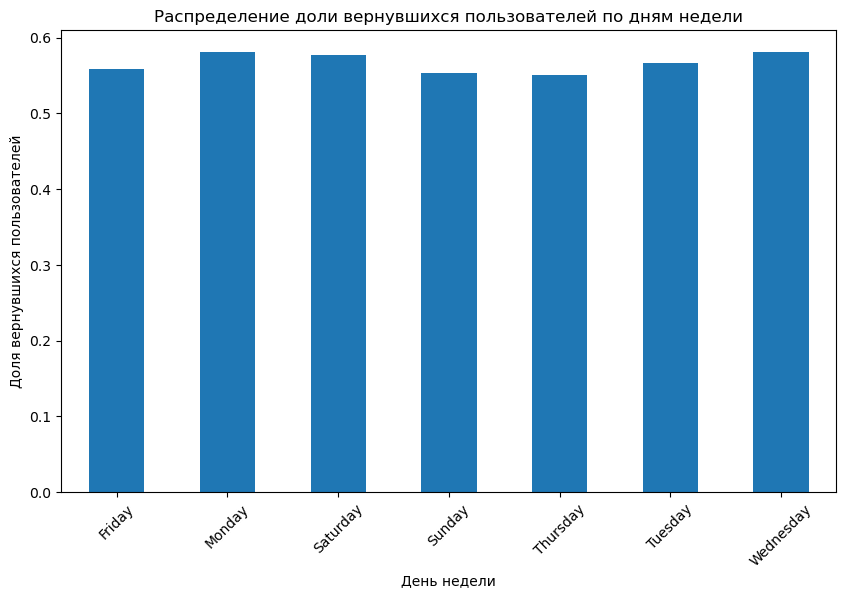

In [115]:
plt.figure(figsize=(10, 6))
days_amount_back.plot(kind='bar', rot=45)
plt.xlabel('День недели')
plt.ylabel('Доля вернувшихся пользователей')
plt.title('Распределение доли вернувшихся пользователей по дням недели')
plt.show()

**Вывод**

Значения в обоих признаках расположены довольно близко. Больше всего заказов происходит в пятницу и субботу, а больше всего вернувшихся пользователей из числа тех, кто совершил первый заказ в понедельник и среду.

Из этого можно сделать вывод о том, что день недели, в который был совершен первый заказ, не влияет на возвращение клиента.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Когда планируют досуг, но возвращаемость остаётся примерно одинаковой — это говорит о том, что день недели первой покупки не влияет на лояльность, а повторное использование сервиса определяется скорее качеством опыта и интересом к мероприятиям

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [116]:
avg_order_time_two_four = user_profile[(user_profile['is_two'] == 1) & (user_profile['is_five'] == 0)]['mean_order_days'].mean()
print('Среднее количество дней между заказами в категории 2-4 заказа:', avg_order_time_two_four)

Среднее количество дней между заказами в категории 2-4 заказа: 23.226535264145884


In [117]:
avg_order_time_five = user_profile[user_profile['is_five'] == 1]['mean_order_days'].mean()
print('Среднее количество дней между заказами в категории 5 и более заказов:', avg_order_time_five)

Среднее количество дней между заказами в категории 5 и более заказов: 13.96294614433729


**Вывод**

Среднее количество дней между заказами в категии `5 и более заказов` меньше почти в два раза, чем в категории `2-4 заказа`. Из чего можно сделать вывод, что чем меньше средний интервал заказов, тем больше вероятность возвращения пользователя.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__
<b>Отлично ✅:</b> По расчетам все верно!
    
</div>
<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__

<b>Рекомендации💡:</b>  Важно иметь в виду, что среднее значение довольно сильно зависит от характера распределения, если есть какие-то сильные выбросы, они могут утянуть среднее значение вверх, хотя основаня масса значений будет гораздо ниже. Поэтому здесь важно было бы построить в том числе гистограммы, наложить их друг на друга (как мы это делали при сравнении выручки), чтобы видеть всю картину в данных.
 
</div>

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [118]:
correlation_matrix = user_profile.phik_matrix(interval_cols=['total_orders', 'mean_revenue', 'mean_order_tickets', 'mean_order_days'])

C:\ProgramData\anaconda3\Lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable user_id is large: 20449. Are you sure this is not an interval variable? Analysis for pairs of variables including user_id can be slow.
  warnings.warn(


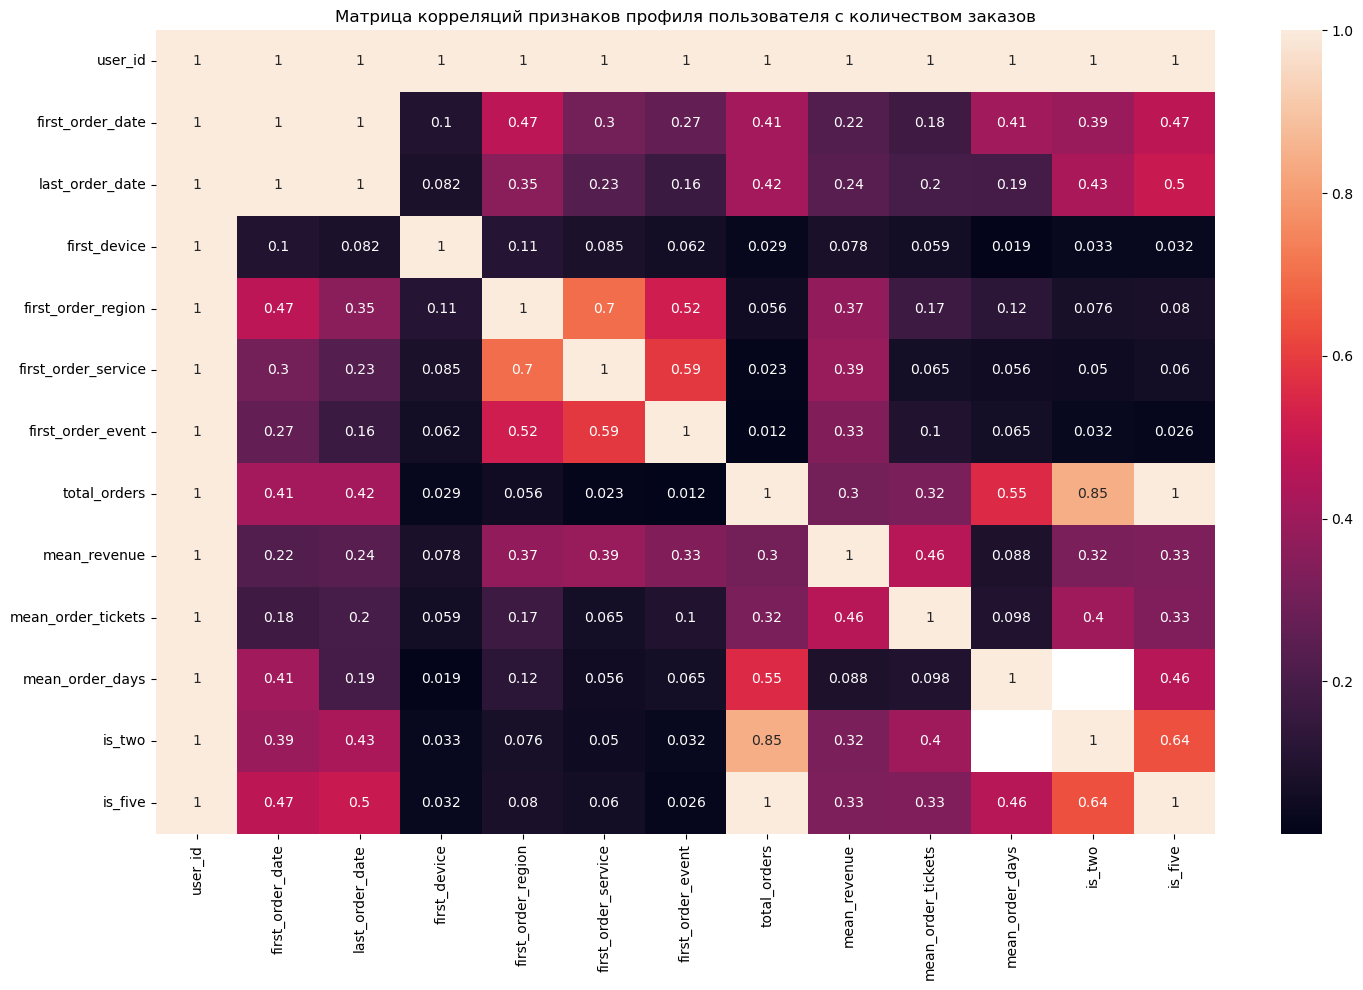

In [119]:
#Выводим матрицу корреляций
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True)
plt.title('Матрица корреляций признаков профиля пользователя с количеством заказов')
plt.tight_layout()
plt.show()

**Вывод**

В матрице корреляций полученные значения не все близки к нулю, поэтому дополнительно выделять сегменты не требуется. 

По полученным значениям можно сделать следующий вывод: поле `total_orders` имеет сильную связь с полем `mean_order_days`, умеренную связь с полями `first_order_date`, `last_order_date` и слабую связь с полями `mean_revenue` и `mean_order_tickets`.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__
    
С этим заданием тоже справились!

</div>
<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__

* Не забываем написать пояснение к шагу.
    
    
* Мы не получили для `orders_count` нулевых корреляций, но ради эксперимента все же можно было бы проверить, насколько сильно поменяются оценки, если сбалансировать разбиение на интервалы.
    
    
* Расцветку для тепловой карты имеет смысл выбирать трехцветную, если диапазон возможных значений от -1 до 1 (например, синий, белый, красный, белый при этом в нуле), или двухцветную, если от 0 до 1 (в 0 - белый, в 1 - красный). Поскольку на 0 будет нейтральный цвет, величину корреляции можно будет воспринимать через интенсивность цвета, а по самому цвету - положительная она или отрицательная.

    
* В выводах Было бы неплохо сделать более явный акцент на том, что поведение клиентов во времени и количество билетов важнее для объяснения повторных покупок, чем их демография или первый выбор сервиса.

</div>


### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

**Финальный вывод**

В данном проекте была проведена работа с данными пользователей Яндекс.Афиши, которые содержали 290611 строк. 

На этапе преобработки данных было выполнено следующее:
 - добавлен новый столбец revenue_rub, обозначающий суммарную выручку в рублях, т.к. часть данных о выручке представлена в тенге;
 - преобразованы типы данных int и float до минимально возможных по размеру в памяти
 - проверены значения категорий в номинальных данных, выполнена проверка на явные и неявные дубликаты
 - были проанализированы численные значения в полях revenue_rub и tickets_count.
 - датафрейм был отфильтрован по значению поля revenue_rub по 99% процентилю сверху и значениям выше нуля снизу. В итоге было отфильтровано 57830 строк, что в относительном выражении - 0.19.

*Основные результаты анализа*

На основе выгруженных данных был создан датафрейм профиля пользователя, содержащий 21700 строк и 10 столбцов. Полученный датафрейм также был проанализирован на выбросы и аномалии, в результате чего было отфильтровано 1251 строка.

Пользователи распределены по сегментам неравномерно, присутствуют, так называемые, "точки входа". Например: по типу мероприятия больше всего пользователей купили билеты на концентры, другое и театр; по устройству - абсолютный лидер mobile; по региону первого заказа больше всего выделяются Широковская область, Североярская область и Каменевский регион; по оператору первого заказа можно выделить топ-5 операторов: Облачко, Билеты в руки, Лови билет!, Мой билет и Билеты без проблем.

Чаще возвращаются пользователи, купившие в первый раз билет на выставки, совершившие первый заказ с мобильного телефона, из Верхнеозерского края и пользующиеся оператором "Зе Бест!".

Был проведен анализ влияния стоимости заказа на возвращение пользователя на платформу.

Пользователи с одним заказом сконцентрированы в левой части графика совместного распределения средней стоимости заказа около значений, близких к нулю.
Пользователи с двумя и более заказами сконцентрированы в области от 0 до примерно 750 рублей по средней выручке.
Из всего этого можно сделать вывод, что пользователи с более дорогими заказами более заинтересованы в сервисе.

Пользователи с 5 и более заказами имеют ярко выраженный пик около значения в 500 рублей средней выручки, в то же время пользователи с 2-4 заказами имеют максимум, близкий к нулю, а остальные значения по выручке далее представлены по нисходящей тенденции. Это снова подтверждает, что пользователи с более дорогими заказами более заинтересованы в возвращении на сервис.

Основная масса пользователей сосредоточена в сегментах 2-3 билета и 3-5 билетов, затем идет сегмент 1-2 билета и меньше всего пользователей в сегменте 5 и более билетов.
При этом примерно одинаковые доли вернувшихся пользователей в сегментах 1-2 билета и 3-5 билетов (44 и 50%), аутсайдер - 5 и более билетов (15%), самая высокая доля вернувшихся в сегменте 2-3 билета (69%).

На основе этого можно сделать следующий вывод: объем заказа действительно влияет на возврат пользователя, но до определенной границы - в данном случае 2-3 билета, большие объемы заказов меньше приводят к возврату пользователей.

Также был проведен анализ зависимости дня недели первого заказа на возвращение пользователя.
Больше всего заказов происходит в пятницу и субботу, а больше всего вернувшихся пользователей из числа тех, кто совершил первый заказ в понедельник и среду.

Из этого можно сделать вывод о том, что день недели, в который был совершен первый заказ, не влияет на возвращение клиента.

Среднее количество дней между заказами в категии 5 и более заказов меньше в два раза, чем в категории 2-4 заказа. Из чего можно сделать вывод, что чем меньше средний интервал заказов, тем больше вероятность возвращения пользователя.

В завершение была построена матрица корреляций количества заказов с остальными признаками профиля пользователя. Был получен следующий результат:

Поле total_orders имеет сильную связь с полем mean_order_days, умеренную связь с полями first_order_date, last_order_date и слабую связь с полями mean_revenue и mean_order_tickets.

**Рекомендации**

По результатам анализа будет релевантна следующая рекомндация: необходимо в первую очередь обратить внимание на пользователей по следующим параметрам: 
 - средний интервал заказов: чем меньше интервал заказов у пользователя, тем он более склонен вернуться на платформу
 - средняя цена заказа: чем выше средняя цена заказа, тем более склонен пользователь вернуться
 - количество билетов в заказе: анализ выявил целевую аудиторию с 2-3 билетами в заказе
 
Также необходимо обратить внимание на регионы и операторов, у которых процент вернувшихся пользователей очень высок, в данном случае это оператор "Зе Бест!" и регион "Верхнеозерский край". Помимо этого, стоит обратить внимание на категорию "выставки" и пользователей десктопных версий. Также необходимо учитывать время, когда покупают билеты больше всего - пятница и суббота.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__
    
С задачей справились! Все ключевые моменты отражены, что позволяет быстро ознакомиться с процессом работы и результатом, не вдаваясь в технический детали. Здорово, что завершаешь проект рекомендациями, основанные на выявленных закономерностях. Предложенные рекомендации логично следуют из анализа и могут быть непосредственно реализованы в маркетинговых стратегиях подогревания и удержания. 

</div>

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**

https://github.com/igorsiv100/ds_second_project.git

<div class="alert alert-block alert-danger">✍
    

__Комментарий от ревьюера №1__


Важно убрать чувствительные данные (логины, пароли). В начале проекта об этом описал
    
<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__    
    
    
Можно еще добавить информацию в readme.md, где указать ключевые моменты проекта. Или зафиксировать цели и полученные выводы.

<div class="alert alert-info"> <b>Комментарии студента:</b> 

Доработал проект, высылаю на проверку!

</div>